# Program to read radar data and plot cappi 3 km
## Data from the São Roque radar
## Zoom over the MASP centered at the radar site
## Read and plot all files in a folder

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import pyart                      
import geopy                     
from geopy import distance
import numpy as np
import glob
import os


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def plot_rings(rings, lon_r, lat_r, color, label,ax):

    """
    Plot rings centered at the radar location

    Parameters:
                           rings (lista): ring size in km
                           lon_r (float): central longitude in degrees
                           lat_r (float): central longitude in degrees
                           color (str): color
                           label (str): label


    Example:
             plot_rings([100], -45.97279, -23.600795, 'gray', label='Radar: 100 km')

    Adapted from: https://github.com/evmpython/curso_radar_UNIFEI_INPE_2024/blob/main/tarefas/Tarefa_2_curso_radar_meteorologico_abril2024_RESPOSTAS.ipynb
    """

    origin = geopy.Point(lat_r, lon_r)

    lons = np.zeros((len(rings), 361))
    lats = np.zeros((len(rings), 361))
    for i, dis in enumerate(rings):
        xpts = []
        ypts = []
        for az in range(361):
            destination = distance.distance(kilometers=dis).destination(origin, az)
            lat2, lon2 = destination.latitude, destination.longitude
            xpts.append(lon2)
            ypts.append(lat2)
        lons[i,:] = xpts[:]
        lats[i,:] = ypts[:]

    for i, anel in enumerate(rings):
        ax.plot(lons[i,:], lats[i,:], color=color, label= label)
     

In [3]:
def plot_cappi(cappi,lat,lon,altitude,data):
    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    shapename_SP = 'filename.shp'
    trans = ccrs.PlateCarree()
    ax.add_geometries(shpreader.Reader(shapename_SP).geometries(),trans,
                      linewidth=1.0, facecolor='none', edgecolor='gray', zorder=3)
    display = pyart.graph.GridMapDisplay(cappi)
    im = display.plot_grid("corrected_reflectivity",
                  level=1,
                  vmin=20,
                  vmax=65,
                  ax=ax,
                  cmap='pyart_NWSRef',
                  colorbar_flag=False)
    plt.title(f'CAPPI {int(display.grid.z["data"][1]) + altitude} m - Reflectividade: {data.strftime("%Y-%m-%d %H:%M")} UTC', fontsize=10)
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    display.plot_colorbar(im,label='Reflectividade (dBZ)',cax=cax,orientation='vertical')
    
    # plot radar lines
    display.plot_crosshairs(lon=lon, lat=lat,ax=ax)

    # plot rings
    plot_rings([100, 200, 250], lon, lat, 'black', label='',ax=ax)

    ax.set_xlabel('Longitude ($^\circ$C)', fontsize=15)
    ax.set_ylabel('Latitude ($^\circ$C)', fontsize=15)
#    plt.show()
#    plt.tight_layout()
    plt.savefig(f'Cappi3km_{data.strftime("%Y%m%d%H%M")}.png',dpi=300, bbox_inches='tight')


In [4]:
radar_list = list(glob.glob(os.path.join('.', '*.mvol')))

In [5]:
radar =  pyart.aux_io.read_gamic(radar_list[0]) # read radar data
lat_radar, lon_radar = radar.latitude['data'][0], radar.longitude['data'][0]
lon_radar

-47.0943

In [6]:
# Estimate the domain size to build cappi 
# Zoom over the MASP centered at the radar
coords_1 = (-24.10, lon_radar)
coords_2 = (-24.10, -45.7)
dist = int(distance.geodesic(coords_1, coords_2).m)
dist

141762

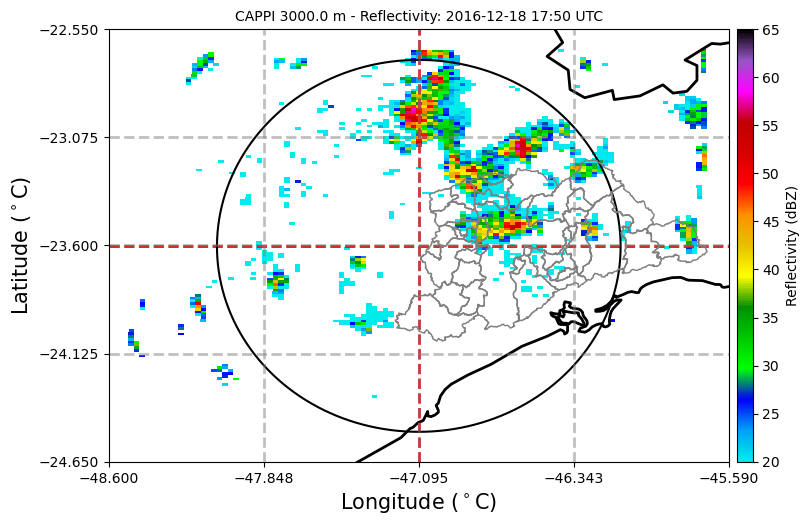

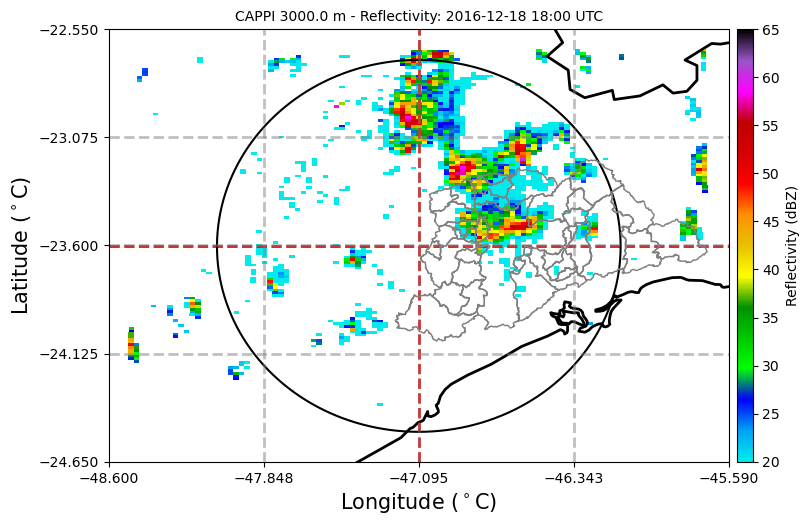

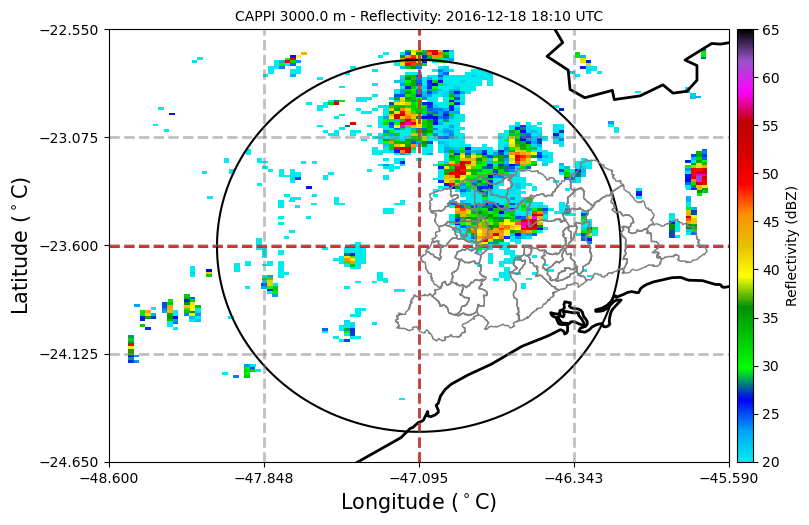

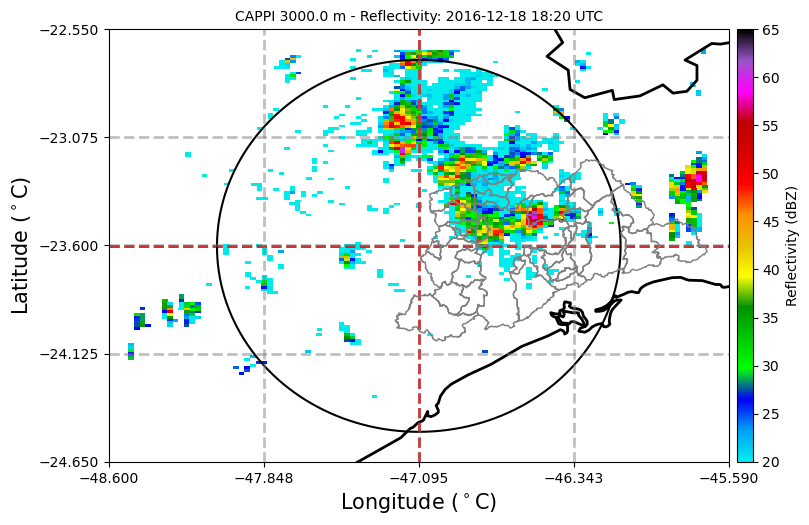

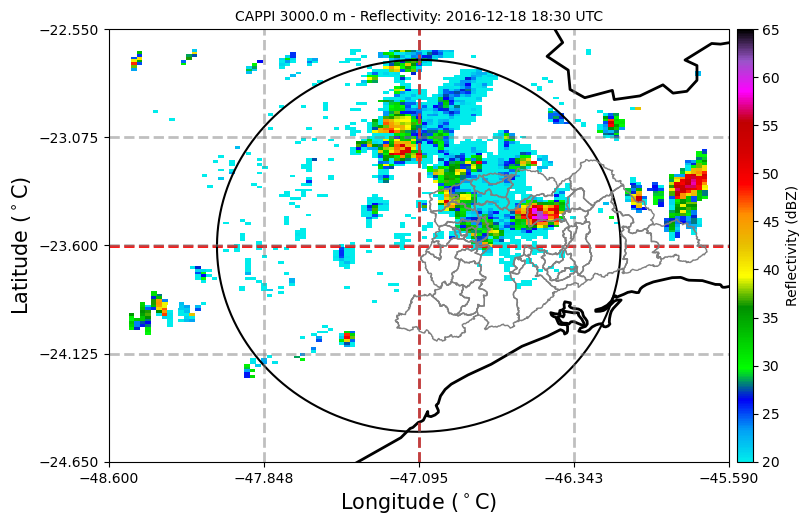

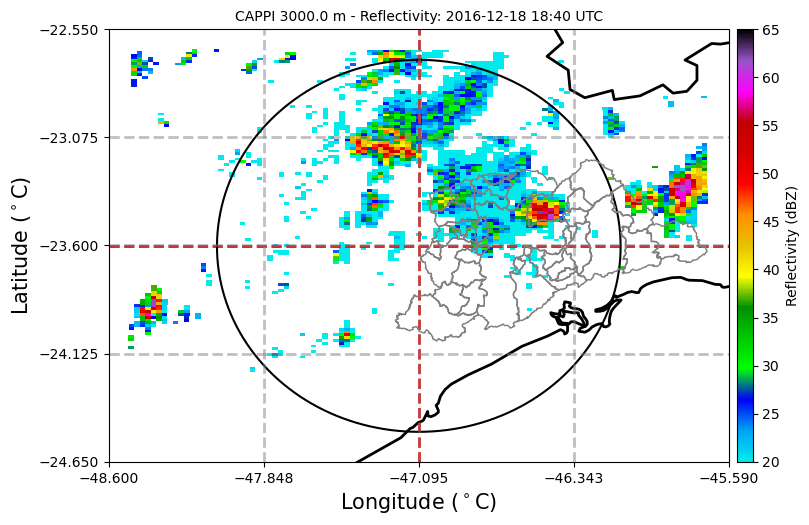

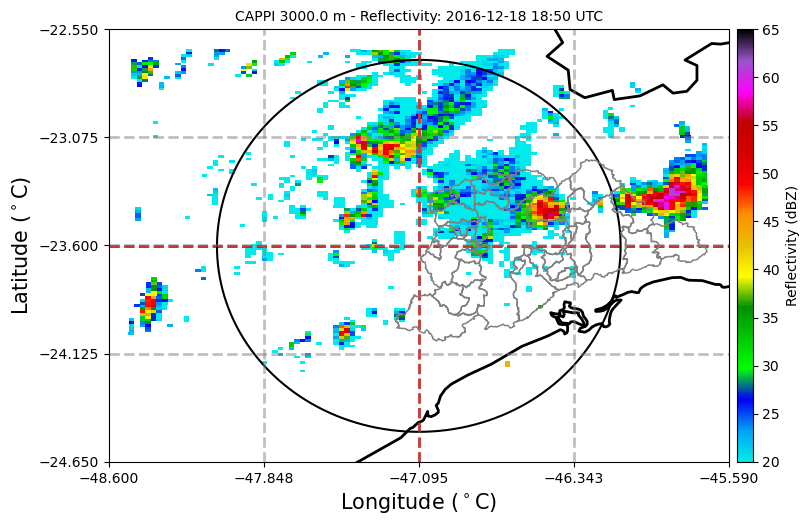

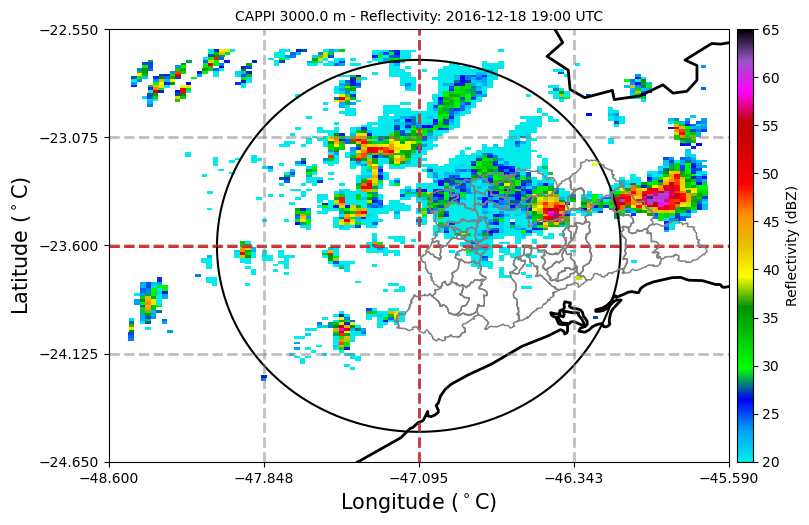

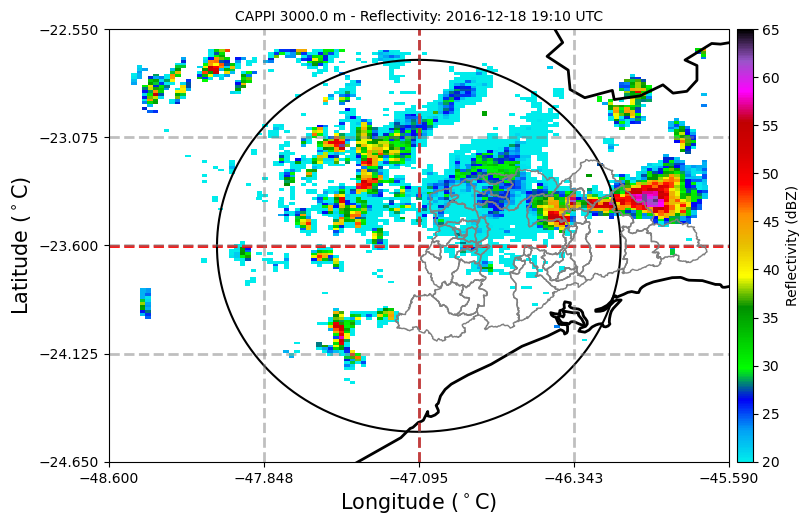

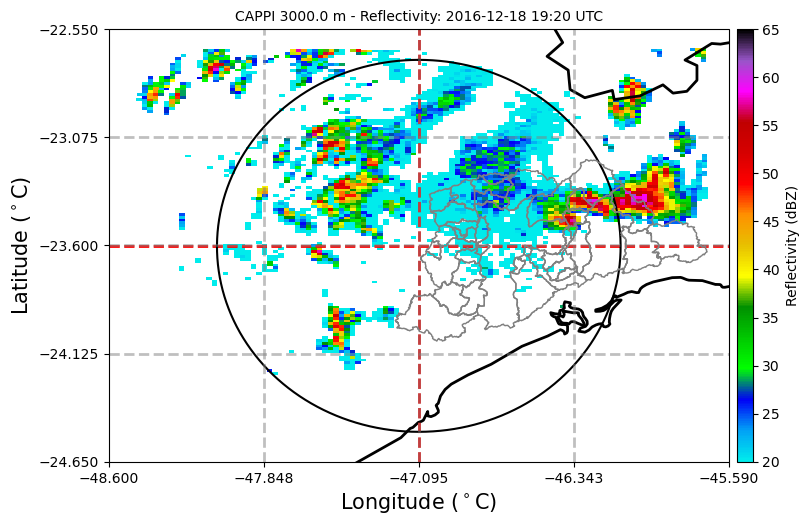

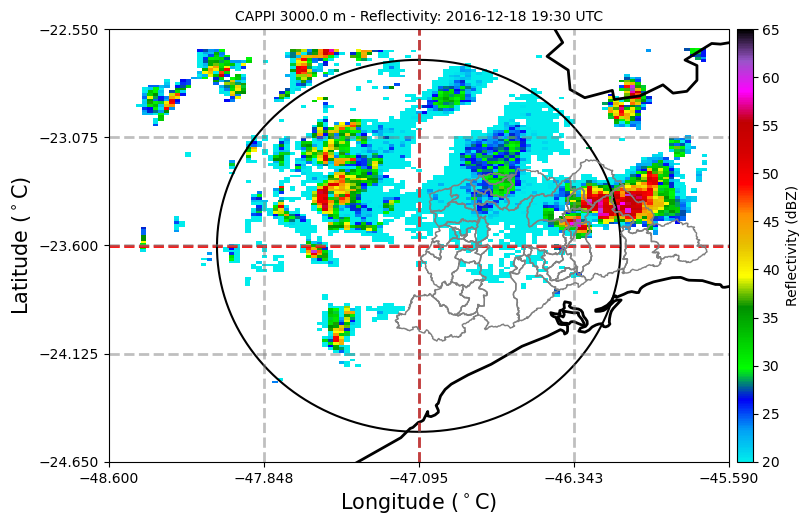

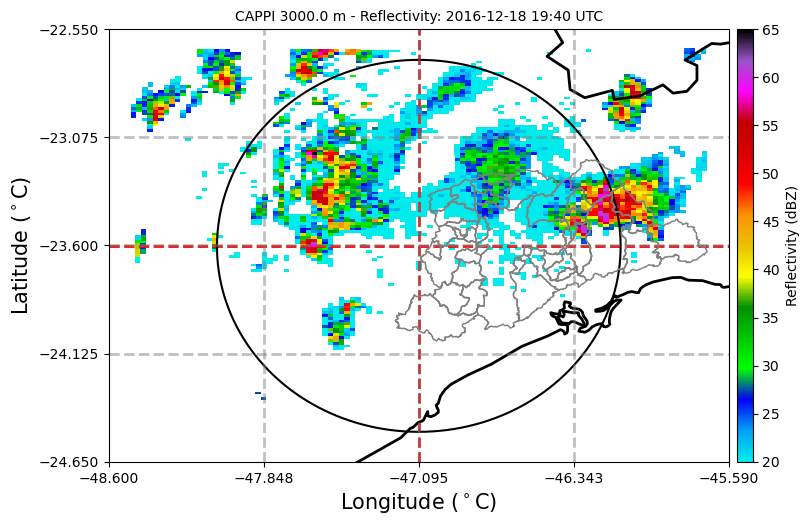

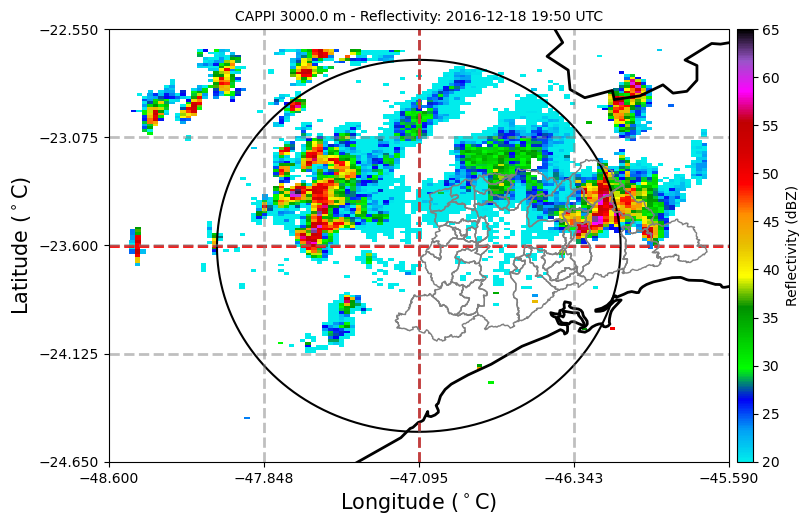

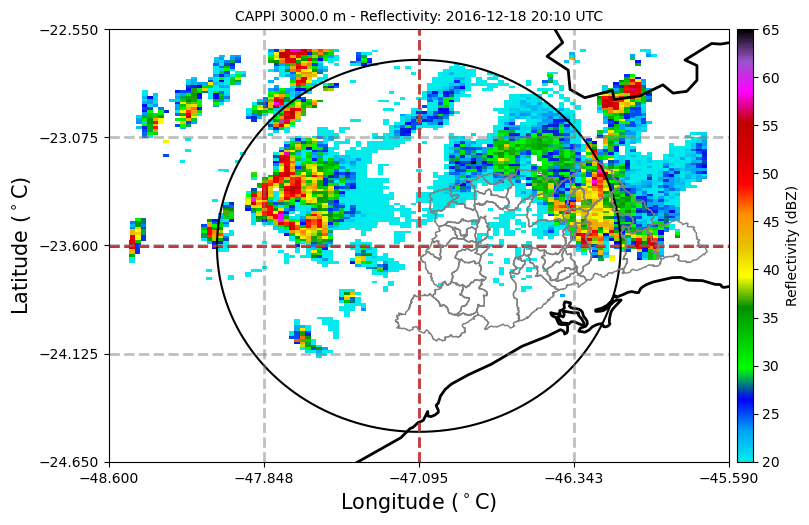

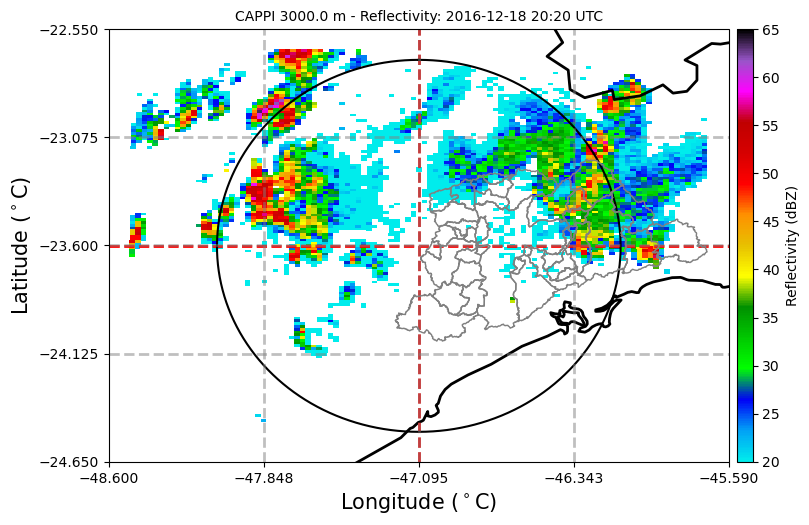

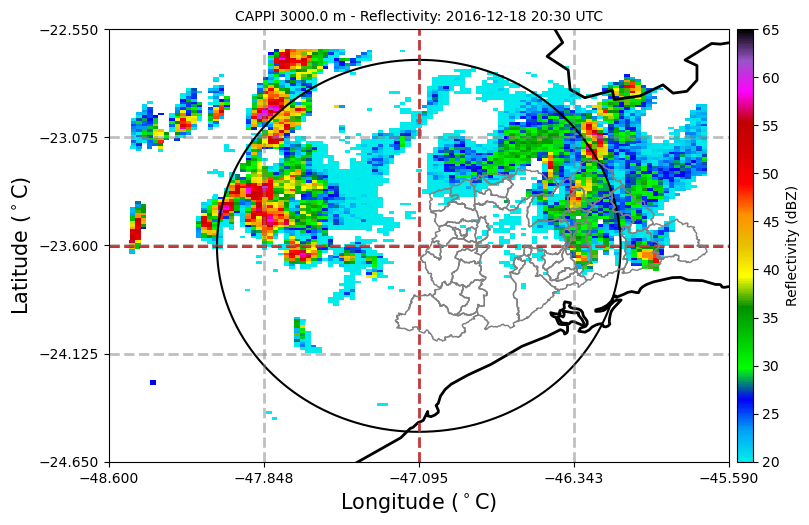

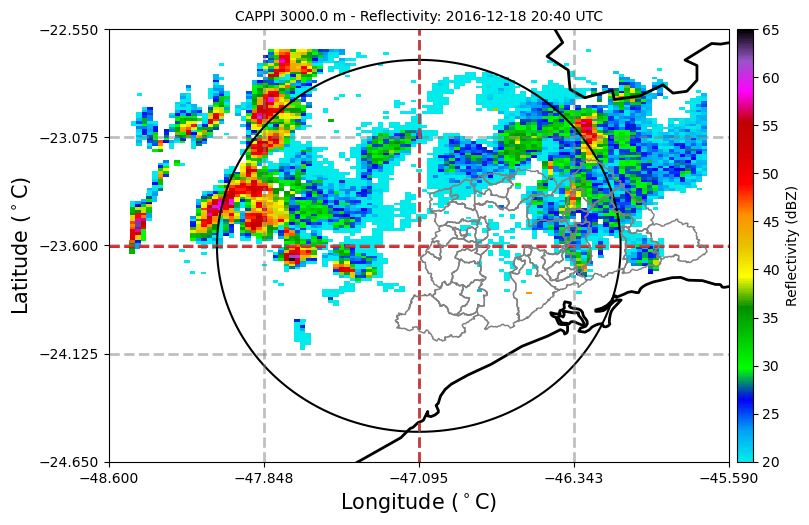

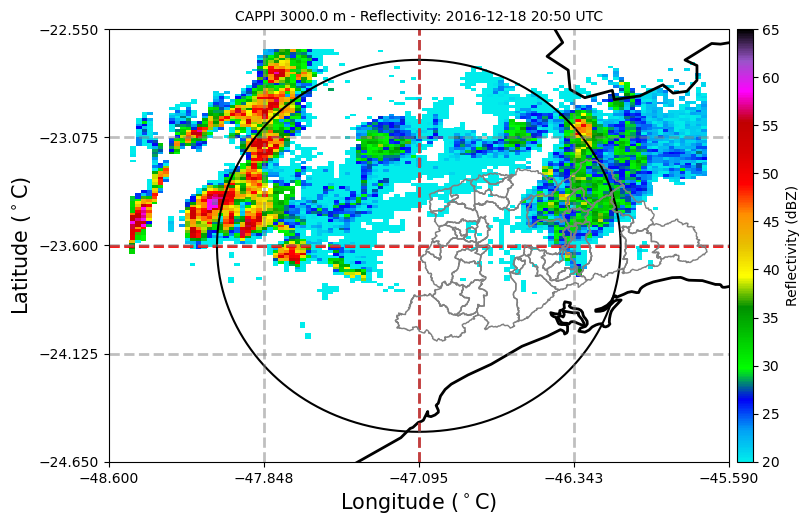

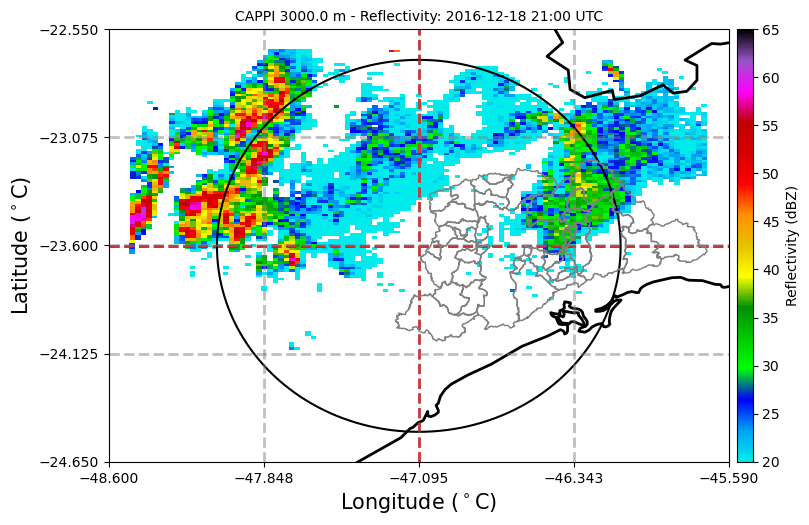

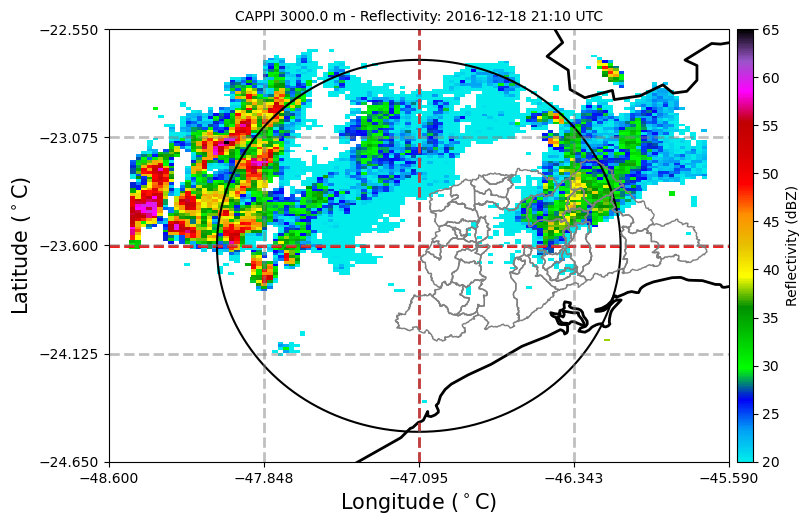

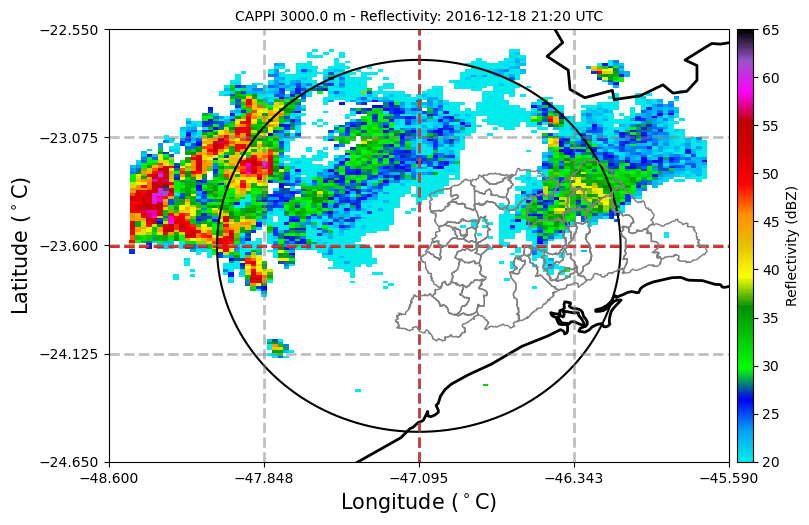

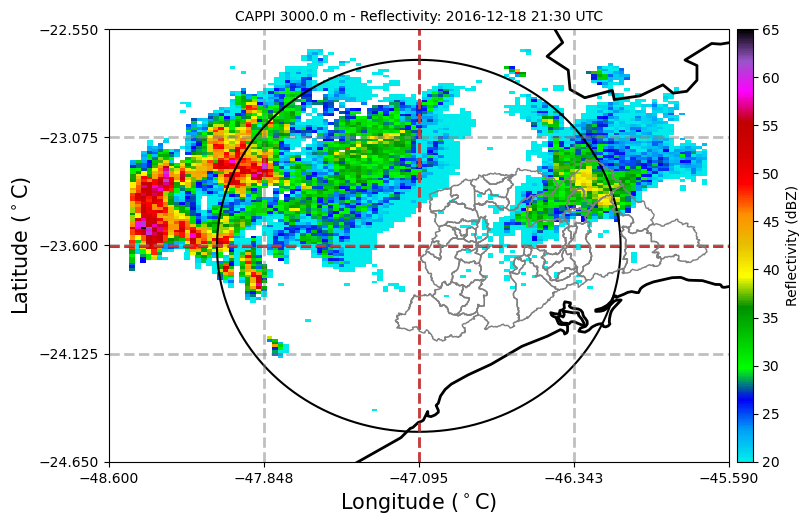

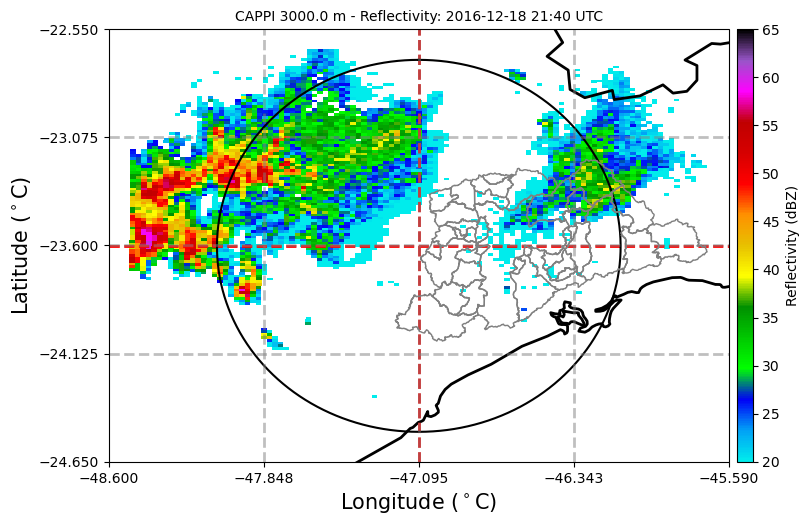

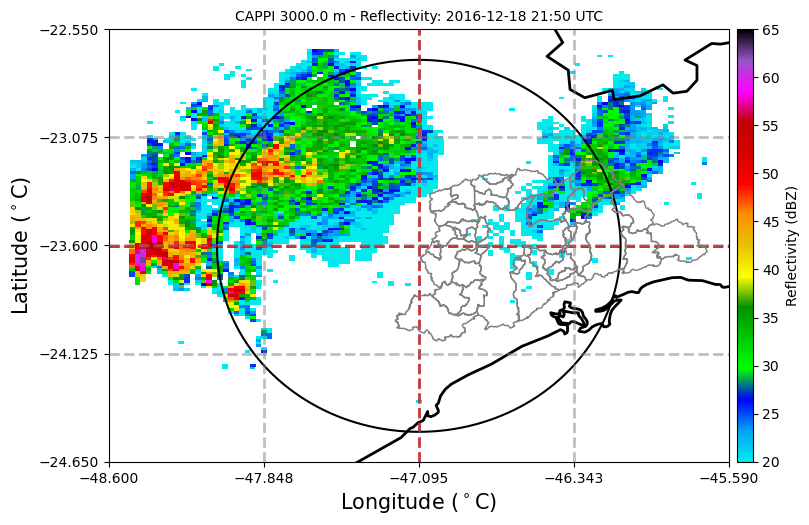

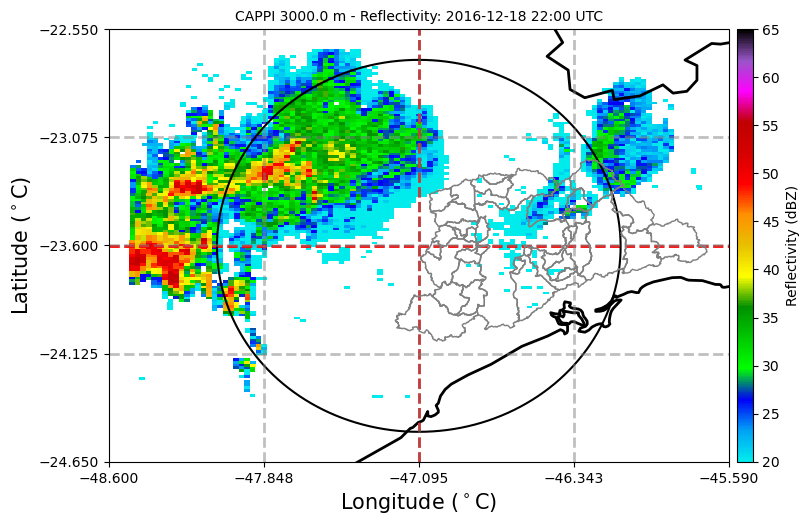

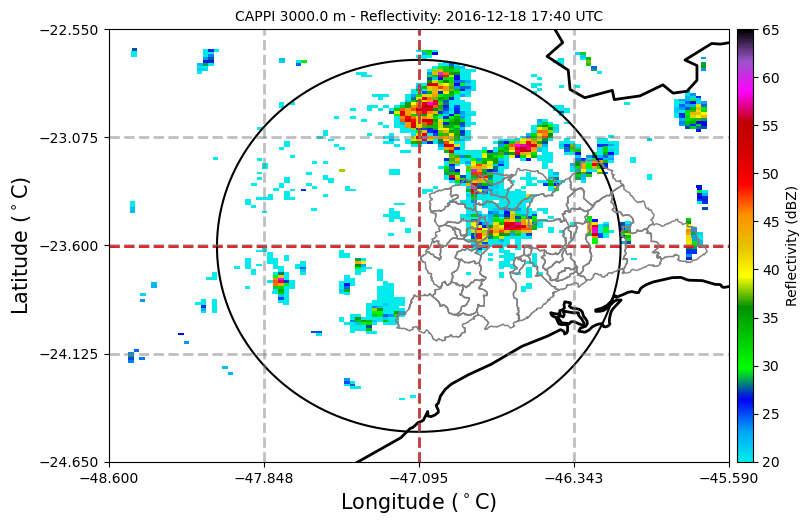

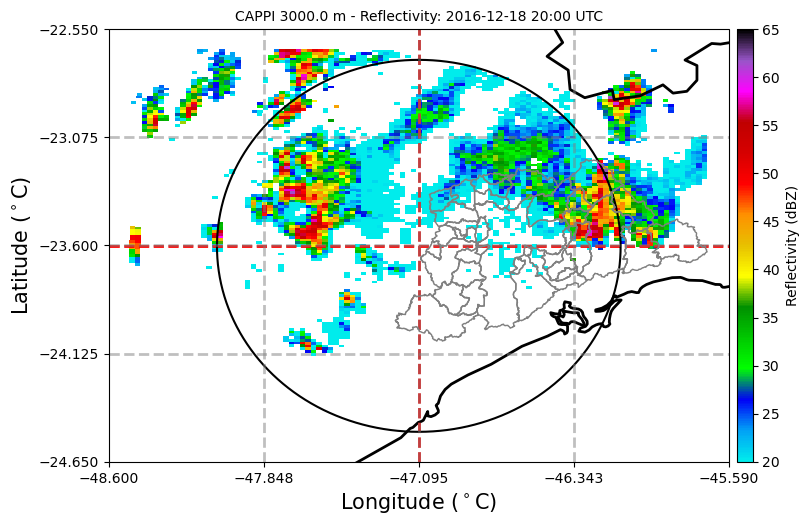

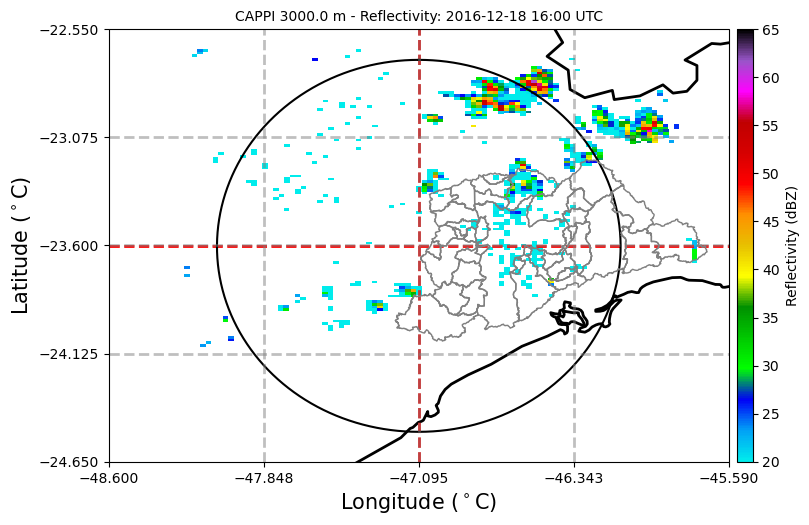

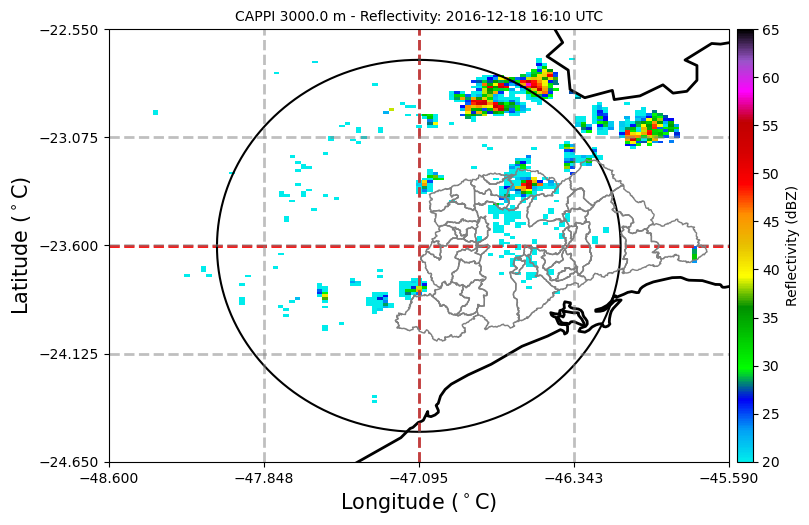

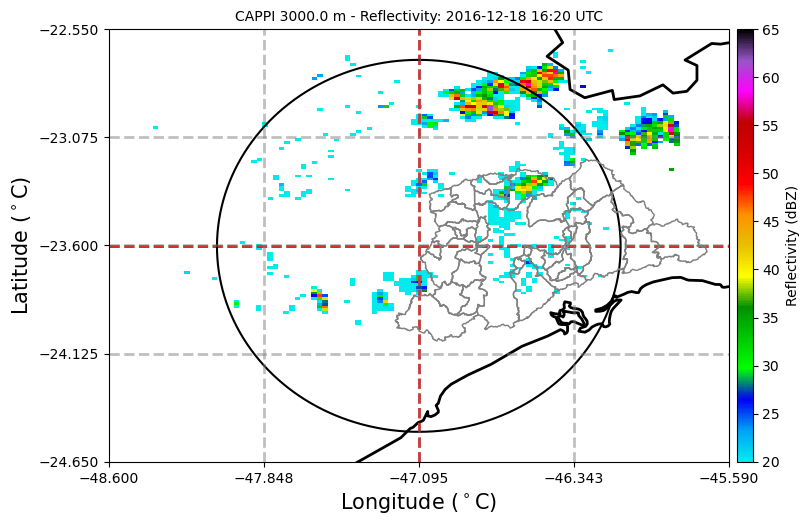

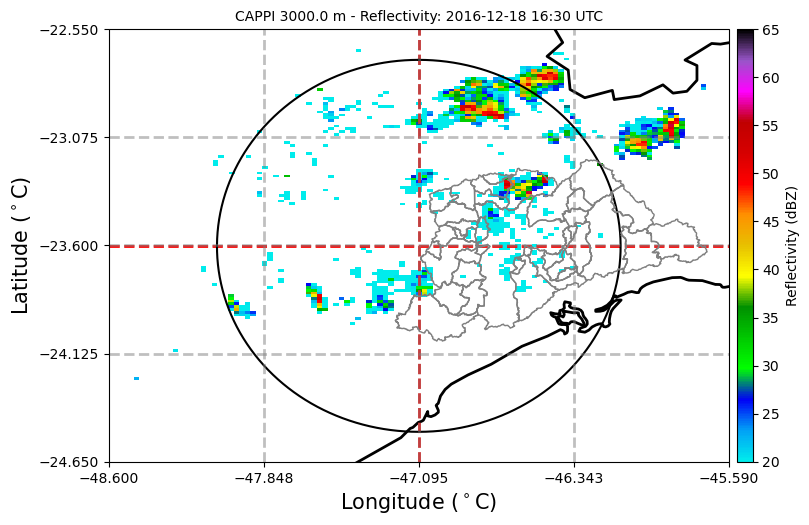

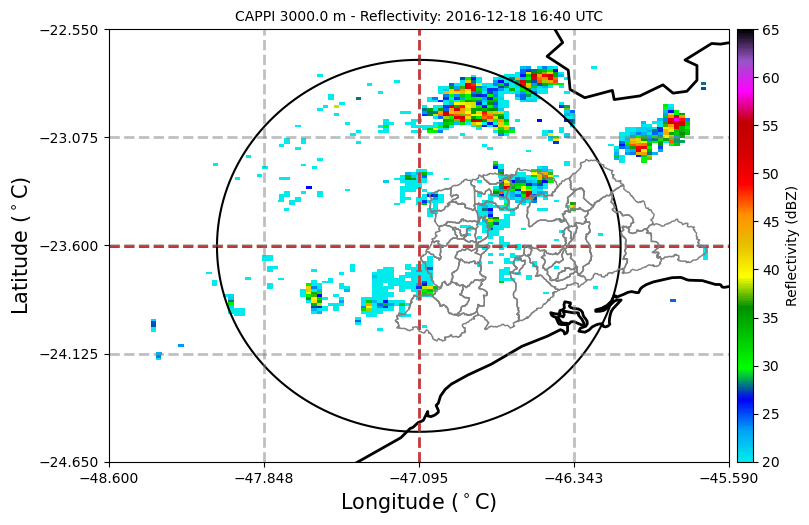

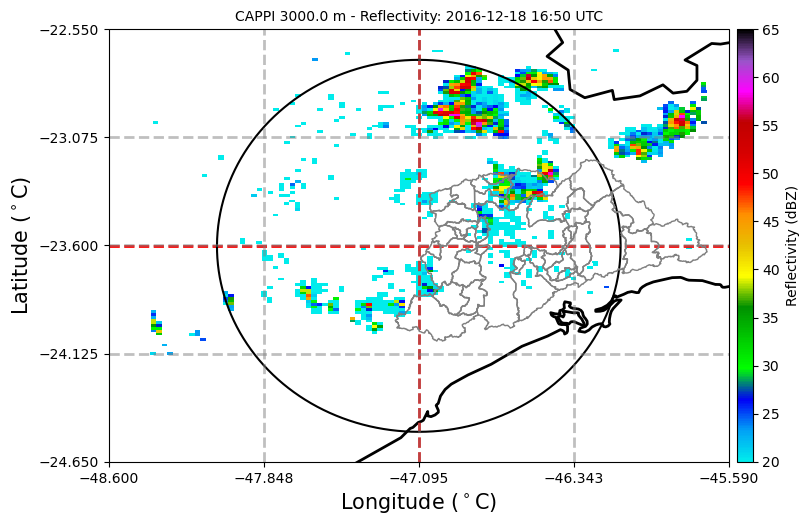

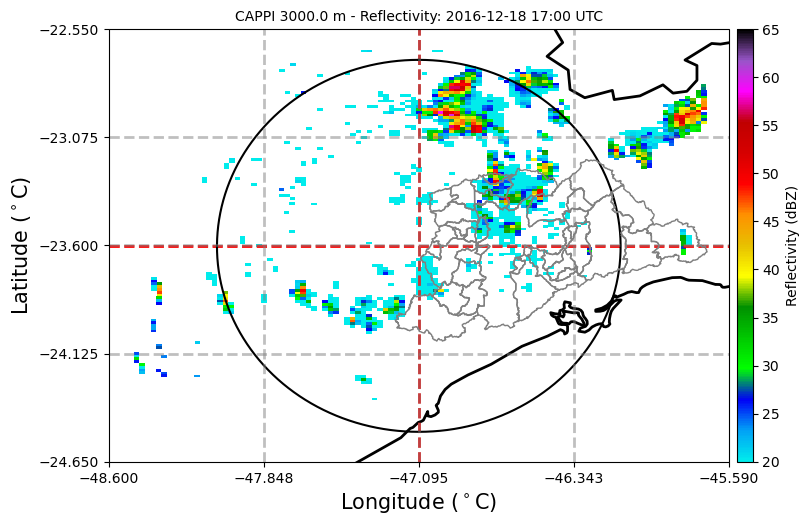

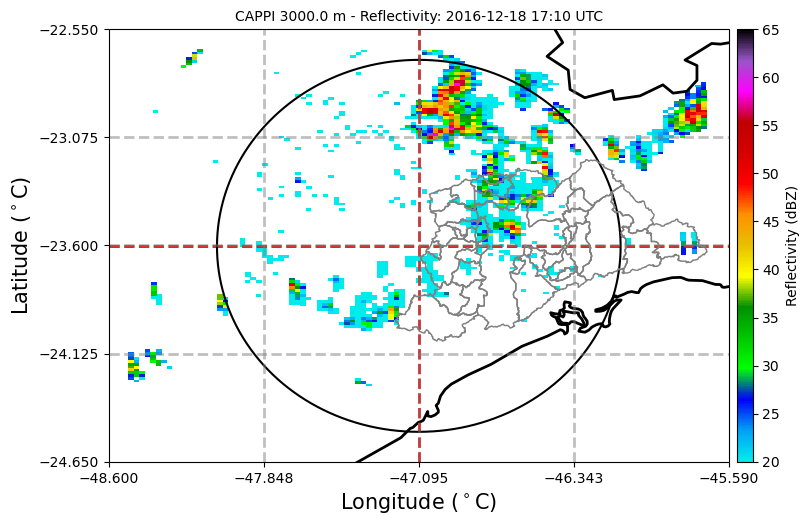

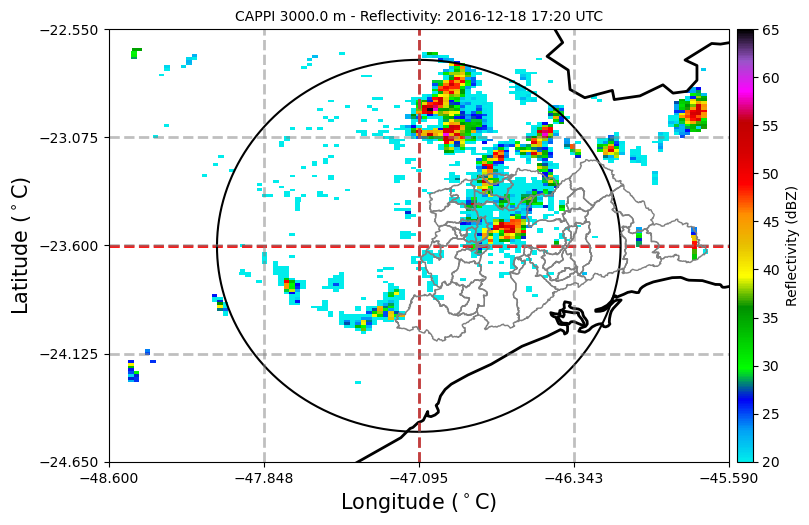

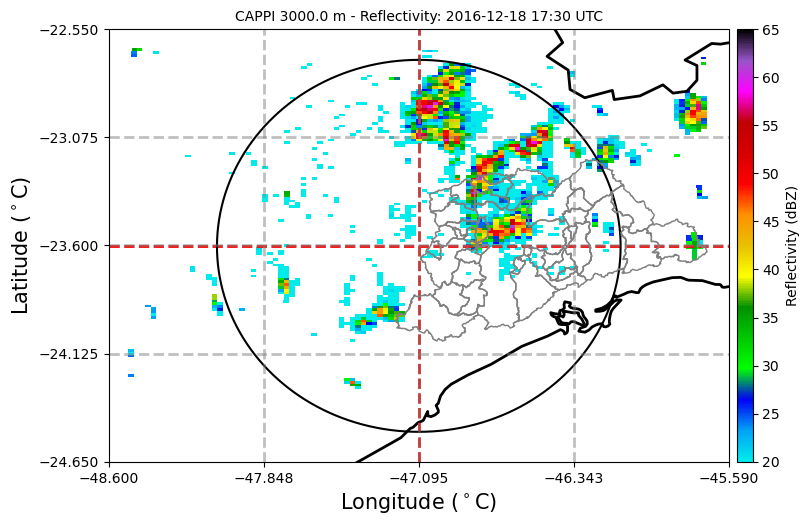

In [7]:
for dados in radar_list:
    radar =  pyart.aux_io.read_gamic(dados) # read radar data
    
    # obtain radar latitude, longitude and altitude
    lat_radar, lon_radar = radar.latitude['data'][0], radar.longitude['data'][0]
    altitude_radar = radar.altitude['data'][0]

    # data limits
    latmin, latmax = radar.gate_latitude['data'].min(), radar.gate_latitude['data'].max()
    lonmin, lonmax = radar.gate_longitude['data'].min(), radar.gate_longitude['data'].max()
    latmin, latmax, lonmin, lonmax

    data_radar = pyart.util.datetime_from_grid(radar,only_use_cftime_datetimes=False)
 
    # create CAPPI
    cappi = pyart.map.grid_from_radars(radar,
                                   grid_shape=(2, 141, 105),
                                   grid_limits=((2000. - altitude_radar, 3000. - altitude_radar),
                                                (-105215., 105215.),
                                                (-141762, 141762)),
                                   grid_origin=(lat_radar, lon_radar),
                                   gridding_algo='map_gates_to_grid',
                                   roi_func='dist_beam',
                                   min_radius=1750.0,
                                   weighting_function='Nearest',
                                   fields=['corrected_reflectivity'])
    plot_cappi(cappi,lat_radar,lon_radar,altitude_radar,data_radar)